In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/house-prices-advanced-regression-techniques/sample_submission.csv
/kaggle/input/house-prices-advanced-regression-techniques/data_description.txt
/kaggle/input/house-prices-advanced-regression-techniques/train.csv
/kaggle/input/house-prices-advanced-regression-techniques/test.csv


# Project Outline

**Step 1: Exploratory Data Analysis**

**Step 2: Preprocessing: Feature Selection**

**Step 3: Preprocessing: Feature Engineering**

**Step 4: Model Selection and evaluation**

**Step 5: Model Deployment**

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## Step 1: Exploratory Data Analysis

In [3]:
df_tr = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/train.csv", index_col = 'Id')
df_t = pd.read_csv("/kaggle/input/house-prices-advanced-regression-techniques/test.csv", index_col = 'Id')

In [4]:
df_tr.shape

(1460, 80)

In [5]:
df_tr.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### **Missing Values**

In [6]:
na_features = [features for features in df_tr.columns if df_tr[features].isnull().sum()>1]
for feature in na_features:
    print(feature,'\t\t', np.round(df_tr[feature].isnull().mean(),3), '%')

LotFrontage 		 0.177 %
Alley 		 0.938 %
MasVnrType 		 0.005 %
MasVnrArea 		 0.005 %
BsmtQual 		 0.025 %
BsmtCond 		 0.025 %
BsmtExposure 		 0.026 %
BsmtFinType1 		 0.025 %
BsmtFinType2 		 0.026 %
FireplaceQu 		 0.473 %
GarageType 		 0.055 %
GarageYrBlt 		 0.055 %
GarageFinish 		 0.055 %
GarageQual 		 0.055 %
GarageCond 		 0.055 %
PoolQC 		 0.995 %
Fence 		 0.808 %
MiscFeature 		 0.963 %


### **Since there are many missing values, we need to find a relationship b/w these features and Sales Price before making impute-remove decision**

Let's do some plotting.

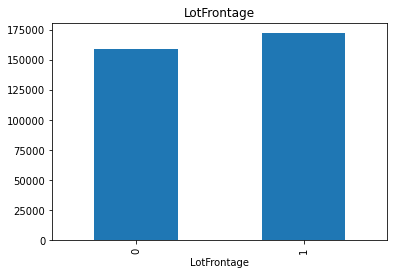

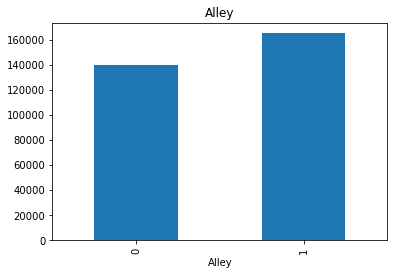

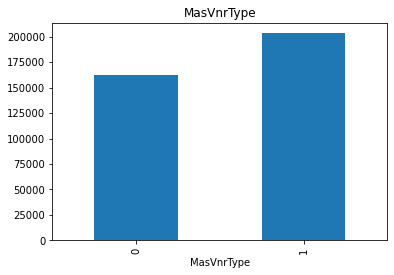

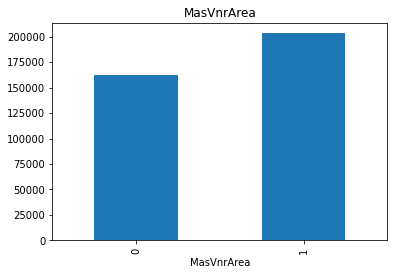

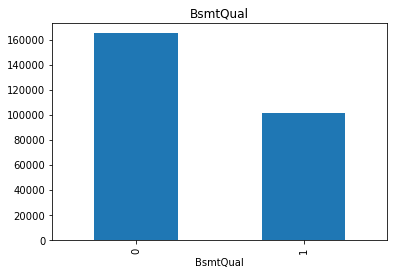

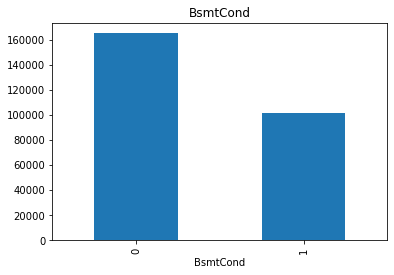

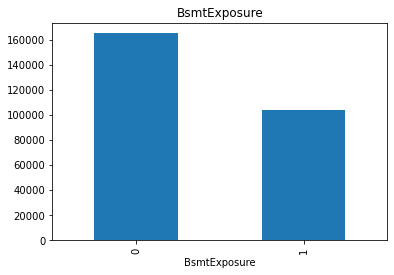

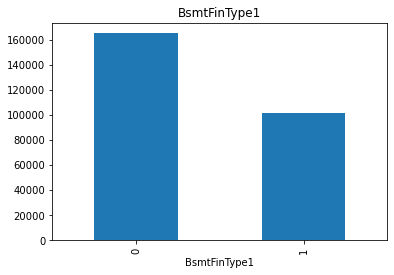

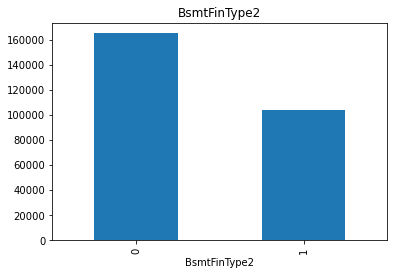

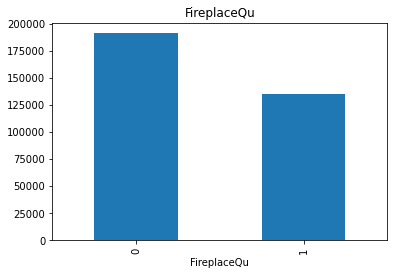

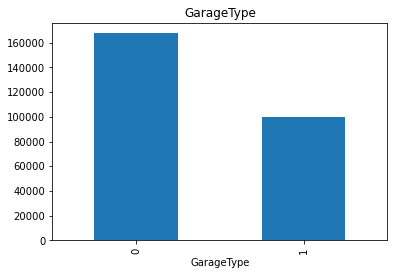

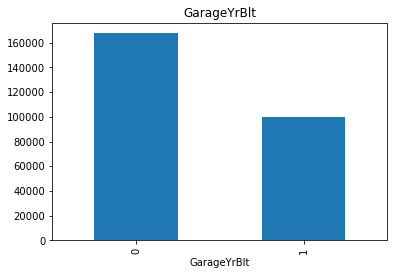

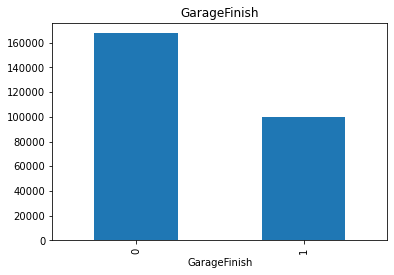

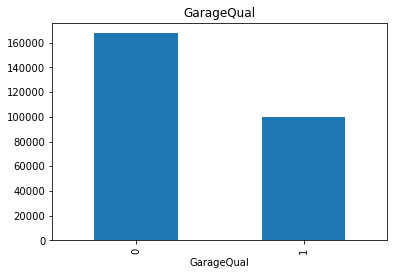

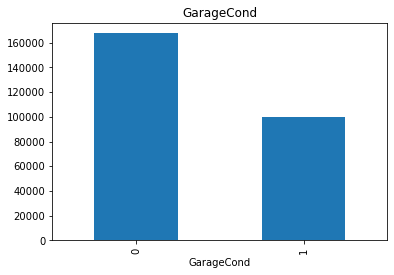

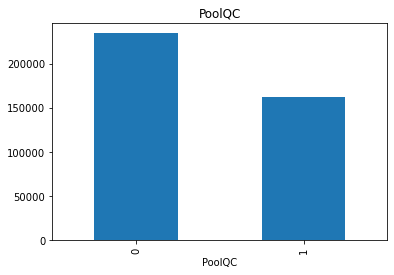

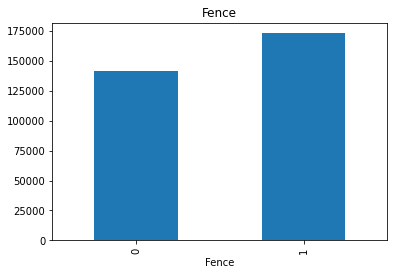

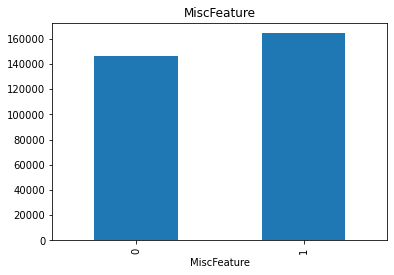

In [55]:
for feature in na_features:
    data = df_tr.copy()
    
    # Indicates 1 if observation is missing
    data[feature]=np.where(data[feature].isnull(),1,0)
    
    data.groupby(feature)['SalePrice'].median().plot.bar(sharey=True)
    plt.title(feature)
    plt.show()

We observe that there's a clear relaitonship between missing values and the target. So we impute instead of removing these features.

### Numerical features

In [63]:
num_features = [feature for feature in df_tr.columns if df_tr[feature].dtypes != 'O']
print(len(num_features))

37


In [66]:
df_tr[num_features].head(3)

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
1,60,65.0,8450,7,5,2003,2003,196.0,706,0,...,0,61,0,0,0,0,0,2,2008,208500
2,20,80.0,9600,6,8,1976,1976,0.0,978,0,...,298,0,0,0,0,0,0,5,2007,181500
3,60,68.0,11250,7,5,2001,2002,162.0,486,0,...,0,42,0,0,0,0,0,9,2008,223500


### **Temporal Features**

Identify features that indicate age, time etc and let's analyze their relationship with SalePrice.

In [67]:
year_features=[feature for feature in num_features if 'Yr' in feature or 'Year' in feature]
year_features

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'YrSold']

In [72]:
for i in year_features: 
    print(i, df_tr[i].unique())

YearBuilt [2003 1976 2001 1915 2000 1993 2004 1973 1931 1939 1965 2005 1962 2006
 1960 1929 1970 1967 1958 1930 2002 1968 2007 1951 1957 1927 1920 1966
 1959 1994 1954 1953 1955 1983 1975 1997 1934 1963 1981 1964 1999 1972
 1921 1945 1982 1998 1956 1948 1910 1995 1991 2009 1950 1961 1977 1985
 1979 1885 1919 1990 1969 1935 1988 1971 1952 1936 1923 1924 1984 1926
 1940 1941 1987 1986 2008 1908 1892 1916 1932 1918 1912 1947 1925 1900
 1980 1989 1992 1949 1880 1928 1978 1922 1996 2010 1946 1913 1937 1942
 1938 1974 1893 1914 1906 1890 1898 1904 1882 1875 1911 1917 1872 1905]
YearRemodAdd [2003 1976 2002 1970 2000 1995 2005 1973 1950 1965 2006 1962 2007 1960
 2001 1967 2004 2008 1997 1959 1990 1955 1983 1980 1966 1963 1987 1964
 1972 1996 1998 1989 1953 1956 1968 1981 1992 2009 1982 1961 1993 1999
 1985 1979 1977 1969 1958 1991 1971 1952 1975 2010 1984 1986 1994 1988
 1954 1957 1951 1978 1974]
GarageYrBlt [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006.

Text(0.5, 1.0, 'Median House Price vs YearSold')

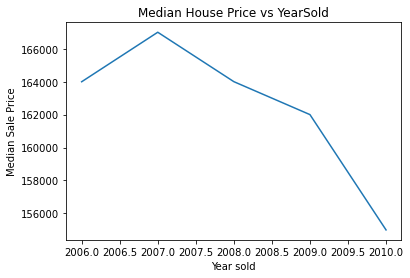

In [79]:
df_tr.groupby('YrSold')['SalePrice'].median().plot()
plt.xlabel('Year sold')
plt.ylabel('Median Sale Price');
plt.title('Median House Price vs YearSold')

This is is as expected. Unlike vintage houses, residential houses often show a depreciation with age. In general, older properties tend to depreciate faster than newer properties, all other things being equal. This is because older properties may require more maintenance and repairs, and may be less desirable to buyers who prefer modern features and amenities. Additionally, changes in market conditions, such as shifts in demographic trends and economic downturns, can also impact the rate of depreciation in a property.

Let's see if the other temporal variables show a similar trend.

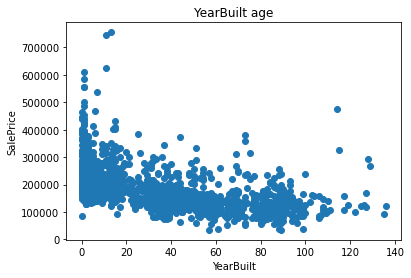

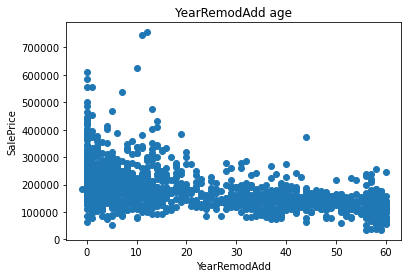

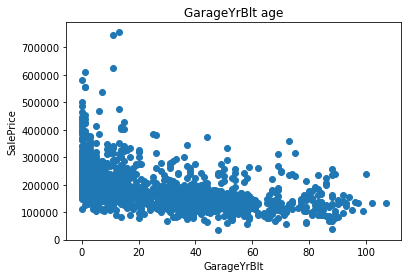

In [95]:
## Lets compare the age when sold by difference of temporal variables with YearSold

for feature in year_features:
    if feature != 'YrSold':
        data = df_tr.copy()
        
        data[feature]=data['YrSold']-data[feature]
        #data.groupby(feature)['SalePrice'].median().plot(kind = 'scatter')
        plt.scatter(data[feature], data['SalePrice'])
        plt.xlabel(feature)
        plt.ylabel('SalePrice')
        plt.title(feature+' age')
        plt.show()

As expected, there seems to be some decreasing linear trend between the age of various temporal features and SalePrice.

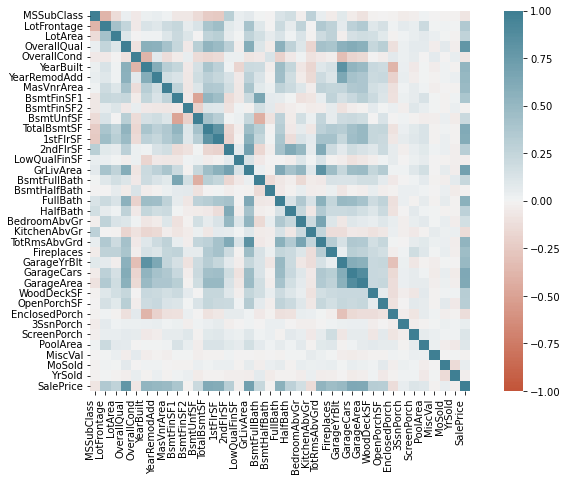

In [36]:

'''plt.figure(figsize=(12,7))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='right'
);'''

In [ ]:
X

In [ ]:
'''#Vertically splits away the price variable from the main data frame
y = X_train_full.SalePrice
X_train_full.drop(['SalePrice'], axis=1, inplace=True)

# Using numeric variables
X = X_train_full.select_dtypes(exclude=['object'])
X_test = X_test_full.select_dtypes(exclude=['object'])

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y, train_size=0.8, test_size=0.2,random_state=0)'''

In [ ]:
'''corr = X_train.corr()
plt.figure(figsize=(12,7))
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    horizontalalignment='right'
);'''

# 3. Investigate for missing values

In [ ]:
'''print(X_train.shape)

# Number of missing values in each column of training data
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])'''